In [176]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [126]:
data = pd.read_csv(r"C:\Users\andre\Рабочий стол\Практикум\Специалист по Data Science Плюс. Часть 6\Часть 6\07 Самостоятельный проект\Churn.csv")

In [127]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [129]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [130]:
data['Geography'].nunique()

3

In [131]:
ohe_data = pd.get_dummies(data, ['Geography','Gender'], drop_first=True)

In [132]:
ohe_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False


In [133]:
print(ohe_data['Tenure'].describe(),'\n',
'Median:',ohe_data['Tenure'].median())

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64 
 Median: 5.0


In [134]:
null = ohe_data[ohe_data['Tenure'].isna() == True].groupby(["Age", "NumOfProducts"])['Tenure'].agg(['count'])
null

count
Age NumOfProducts       
18  1                  0
19  1                  0
20  1                  0
    2                  0
21  1                  0
...                  ...
74  2                  0
75  1                  0
    2                  0
78  1                  0
92  1                  0

[127 rows x 1 columns]

In [135]:
median_tenure = ohe_data.groupby(["Age", "NumOfProducts"])["Tenure"].agg({'median'}).rename(columns={'median':'Tenure'})
median_tenure


Tenure
Age NumOfProducts        
18  1                 4.0
    2                 5.0
19  1                 5.0
    2                 5.5
20  1                 4.0
...                   ...
84  1                 8.0
85  2                10.0
88  2                10.0
92  1                 NaN
    2                 1.0

[212 rows x 1 columns]

In [136]:
median = ohe_data['Tenure'].median()
ohe_data['Tenure'] = ohe_data['Tenure'].fillna(median)

In [137]:
col = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [138]:
scaler = StandardScaler()
ohe_data[col] = scaler.fit_transform(ohe_data[col])

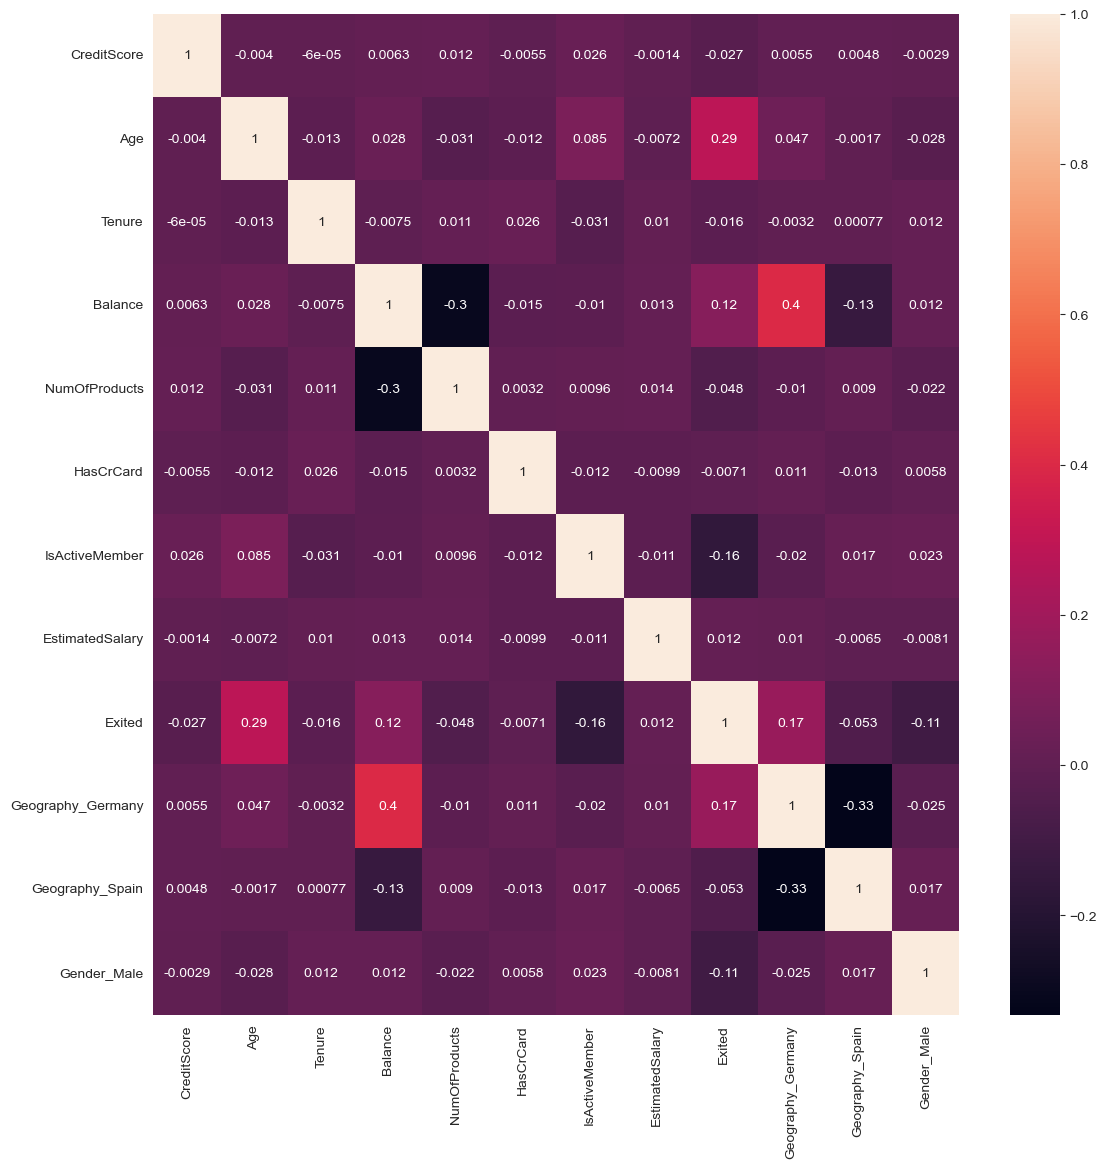

In [139]:
fig = plt.figure(figsize=(13,13))
sns.heatmap(ohe_data.corr(), annot=True)
plt.show()

## Исследование задачи

In [140]:
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [141]:
x = ohe_data.drop('Exited', axis=1)
y = ohe_data['Exited']

In [142]:
x_train, x_test, y_train , y_test = train_test_split(x, y, test_size=0.25, random_state=42)

## Борьба с дисбалансом

In [143]:
def oversample(features, targets):
    zeros_features = features[targets == 0]
    zeros_targets = targets[targets == 0]
    ones_targets = targets[targets == 1]
    ones_features = features[targets == 1]

    delta = targets[targets == 0].count() // targets[targets == 1].count()

    x_train_resampled = pd.concat([zeros_features]+ [ones_features] * delta, axis=0).reset_index(drop=True)
    y_train_resampled = pd.concat([zeros_targets]+ [ones_targets] * delta, axis=0).reset_index(drop=True)

    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled)

    return x_train_resampled, y_train_resampled

In [144]:
x_train_res, y_train_res = oversample(x_train, y_train)

## Тестирование модели

In [147]:
log_reg = LogisticRegression()
log_reg.fit(x_train_res, y_train_res)
predictions = log_reg.predict(x_test)
f1 = metrics.f1_score(y_test, predictions)
auc = metrics.roc_auc_score(y_test, predictions)
tpr = metrics.recall_score(y_test, predictions)
fpr = metrics.precision_score(y_test, predictions)

print('f1:',f1,'\n',
      'auc-roc:',auc, '\n',
      'recall:',tpr, '\n',
      'precision:',fpr)

f1: 0.5036674816625917 
 auc-roc: 0.705772829689068 
 recall: 0.6217303822937625 
 precision: 0.4232876712328767


In [161]:
best_dep, best_tpr = 0,0
for depth in range(1,21,1):
    rand_forest = RandomForestClassifier(max_depth=depth, random_state=42)
    rand_forest.fit(x_train_res, y_train_res)
    predictions = rand_forest.predict(x_test)
    f1 = metrics.f1_score(y_test, predictions)
    auc = metrics.roc_auc_score(y_test, predictions)
    tpr = metrics.recall_score(y_test, predictions)
    fpr = metrics.precision_score(y_test, predictions)
    if tpr > best_tpr:
        best_tpr = tpr
        best_dep = depth

print(#'f1:',f1,'\n',
  #'auc-roc:',auc, '\n',
'recall:',best_dep, best_tpr) #, '\n',
  #'precision:',fpr)

recall: 6 0.6841046277665996


In [175]:

rand_forest = RandomForestClassifier(n_estimators=11, random_state=42, max_depth=6)
rand_forest.fit(x_train_res, y_train_res)
predictions = rand_forest.predict(x_test)
f1 = metrics.f1_score(y_test, predictions)
auc = metrics.roc_auc_score(y_test, predictions)
tpr = metrics.recall_score(y_test, predictions)
fpr = metrics.precision_score(y_test, predictions)


print('f1:',f1,'\n',
    'auc-roc:',auc, '\n',
    'recall:',best_est, best_tpr) #, '\n',
#'precision:',fpr)

f1: 0.6152466367713004 
 auc-roc: 0.776423393079395 
 recall: 11 0.6901408450704225


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*